<a href="https://colab.research.google.com/github/aymanmostafa11/signature-identifiation-and-verification/blob/main/notebooks/Signature_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import numpy as np
import pandas as pd
import glob
import random
import cv2
from matplotlib import pyplot as plt

random.seed(42)

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
TRAIN_PATH = '/content/drive/MyDrive/train_test_dataset/train'
TEST_PATH = '/content/drive/MyDrive/train_test_dataset/test'

IMG_SIZE = (256, 256)
INPUT_SIZE = (256, 256, 3)

In [4]:
def read_folders(root_path):
  return glob.glob(root_path + '/*', recursive = True)

### Creating Triplets
Every sample consists of a (anchor, positive, negative) triplet.

In [5]:
def create_triplets(folders_list):

  triplets = []

  for folder in folders_list:
    os.chdir(folder)
    labels_path = [file for file in glob.glob('*.csv')][0]
    labels_dict = pd.read_csv(labels_path, index_col=0, squeeze=True).to_dict()
    forged_list = [dict_item for dict_item in labels_dict if labels_dict[dict_item] == 'forged']
    real_list = [dict_item for dict_item in labels_dict if labels_dict[dict_item] == 'real']
    
    for i in range(len(real_list)):
      for j in range(len(real_list)):
        if i==j:
          continue
        anchor = real_list[i]
        positive = real_list[j]
        for negative in forged_list:
          triplets.append([folder, (anchor, positive, negative)])

  random.shuffle(triplets)
  
  return triplets

In [8]:
train_triplets = create_triplets(read_folders(TRAIN_PATH))
test_triplets = create_triplets(read_folders(TEST_PATH))

print(f"Length of training triplets: {len(train_triplets)}")
print(f"Length of test triplets: {len(test_triplets)}")

Length of training triplets: 38000
Length of test triplets: 240


Example from train triplets

In [9]:
images = []
for i in range(5):
  folder, (a, p, n) = train_triplets[i]
  images.append([folder, a, p, n])
  print(train_triplets[i])

['/content/drive/MyDrive/train_test_dataset/train/personC', ('personC_24.png', 'personC_45.png', 'personC_44.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_48.png', 'personD_36.png', 'personD_11.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_39.png', 'personD_20.png', 'personD_4.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_46.png', 'personD_20.png', 'personD_10.png')]
['/content/drive/MyDrive/train_test_dataset/train/personB', ('personB_41.png', 'personB_26.png', 'personB_45.png')]


### Visualizing Triplets

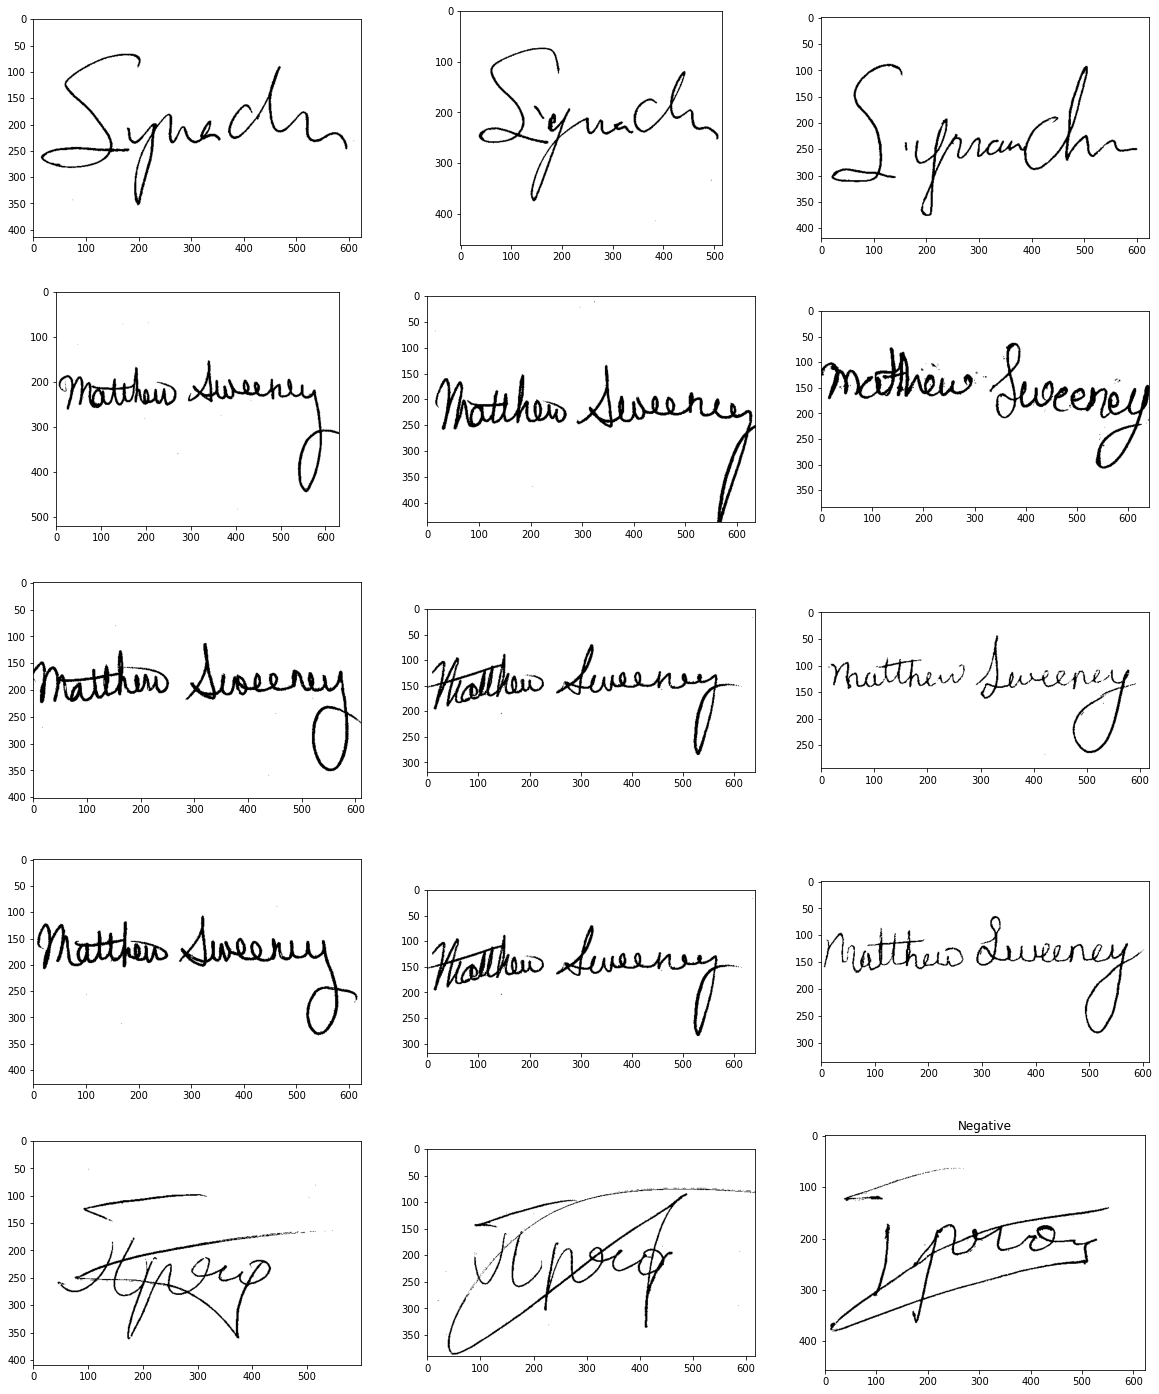

In [10]:
rows = 5
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 25))

for i in range(rows):
  axes[i, 0].imshow(plt.imread(images[i][0]+'/'+images[i][1]))
  axes[i, 1].imshow(plt.imread(images[i][0]+'/'+images[i][2]))
  axes[i, 2].imshow(plt.imread(images[i][0]+'/'+images[i][3]))


In [11]:
def read_image(image_name, folder_path):

  path = os.path.join(folder_path, image_name)
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMG_SIZE)
  
  return image

### Generating Batches
Now we'll make a function to create batches of triplets for the siamese network to train on, the triplets are returned in seperate lists

In [12]:
def batch_generator(triplets, batch_size = 128):

  num_of_batches = len(triplets)//batch_size
  
  for i in range(num_of_batches):

    batch = read_triplets(triplets[i*batch_size:batch_size*(i+1)])

    yield batch

In [13]:
def read_triplets(triplets):
  
  anchors, positives, negatives = [], [], []
  
  for j in range(len(triplets)):

    folder, (a, p, n) = triplets[j]
    anchors.append(read_image(a, folder))
    positives.append(read_image(p, folder))
    negatives.append(read_image(n, folder))
    
  anchors = np.array(anchors)
  positives = np.array(positives)
  negatives = np.array(negatives)

  return [anchors, positives, negatives]

In [14]:
from tensorflow.keras import backend, layers, metrics
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

In [15]:
def get_encoder(input_shape):
   """ Returns the image encoding model """

   pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
   )

   for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False


   encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
  
  
   return encode_model

In [16]:
class distance_layer(layers.Layer):
  # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    anchor_positive_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    anchor_negative_distance = tf.reduce_sum(tf.square(anchor - negative), -1) 

    return (anchor_positive_distance, anchor_negative_distance)

In [17]:
def get_siamese_network(input_shape = (256, 256, 3)):
  encoder = get_encoder(input_shape)

  # Input Layers for the images
  anchor_input = layers.Input(input_shape, name = "Anchor_Input")
  positive_input = layers.Input(input_shape, name = "Positive_Input")
  negative_input = layers.Input(input_shape, name = "Negative_Input")


  # Generate the encodings (feature vectors) for the images
  encoded_anchor = encoder(anchor_input)
  encoded_positive = encoder(positive_input)
  encoded_negative = encoder(negative_input)

  # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
  distances = distance_layer()(
      encoder(anchor_input),
      encoder(positive_input),
      encoder(negative_input)
  )
  
  # Creating the Model
  siamese_network = Model(
    inputs  = [anchor_input, positive_input, negative_input],
    outputs = distances,
    name = "Siamese_Network"
    )

  return siamese_network


In [18]:
siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                   

In [19]:
class SiameseModel(Model):
  # Builds a Siamese model based on a base-model
  def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

  def call(self, inputs):
        return self.siamese_network(inputs)

  def train_step(self, data):
    # GradientTape get the gradients when we compute loss, and uses them to update the weights   
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)

    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))  

    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}


  def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


  def _compute_loss(self, data):
        anchor_positive_distance, anchor_negative_distance = self.siamese_network(data)
        loss = tf.maximum(anchor_positive_distance -  anchor_negative_distance + self.margin, 0.0)

        return loss      
 
  @property
  def metrics(self):
    # We need to list our metrics so the reset_states() can be called automatically
    return [self.loss_tracker]      

In [ ]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate = 1e-3, epsilon = 1e-01)
siamese_model.compile(optimizer = optimizer)

In [ ]:
def test(data):

  triplets = read_triplets(data)
  pred = siamese_model.predict(triplets)
  positive_scores = pred[0]
  negative_scores = pred[1]
  accuracy = np.sum(np.array(positive_scores) < np.array(negative_scores)) / len(positive_scores)

  return accuracy

### Training the Model
Now we'll be training the model on batches of triplets.
The number and size of batches was set to avoid colab's time and memory constraints.

In [ ]:
def train(data, epochs, batch_size=128, verbose=True, save_all=False):

  best_accuracy = 0
  for epoch in range(epochs):

    print(f"\nEPOCH {epoch+1}/{epochs}:")

    batch_losses = []
    for batch in batch_generator(data, batch_size=batch_size):

      batch_loss = siamese_model.train_on_batch(batch)
      batch_losses.append(batch_loss)
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    test_acc = test(test_triplets)

    if verbose:
      print(f" loss: {epoch_loss: .4f}  - test_acc: {test_acc: .4f}")

    if save_all or best_accuracy < test_acc:
      siamese_model.save_weights("siamese model")
      best_accuracy = test_acc

  siamese_model.save_weights("siamese-model-final")


In [ ]:
BATCH_SIZE = 128
EPOCHS = 2
#train(train_triplets, epochs=EPOCHS, batch_size=BATCH_SIZE)


EPOCH 1/2:
8/8 [==============================] - 9s 617ms/step
 loss:  0.1877  - test_acc:  0.9917

EPOCH 2/2:
8/8 [==============================] - 3s 465ms/step
 loss:  0.0553  - test_acc:  0.9000


#### Saving the Model

In [21]:
def extract_encoder(model):
    encoder = get_encoder(INPUT_SIZE)
    i=0
    for encoder_layer in model.layers[0].layers[3].layers:
        layer_weight = encoder_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

In [ ]:
encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

### Using Encoder to create a database of signature embeddings

In [42]:
os.chdir('/content')
loaded_encoder = tf.keras.models.load_model('saved-encoder.h5')

In [ ]:
def create_embeddings(encoder, path):
  embeddings_dict = {}
  for folder in read_folders(path):
    person_id = os.path.basename(folder)
    os.chdir(folder)
    labels_path = [file for file in glob.glob('*.csv')][0]
    labels_dict = pd.read_csv(labels_path, index_col=0, squeeze=True).to_dict()
    real_signature = [dict_item for dict_item in labels_dict if labels_dict[dict_item] == 'real'][0]
    image = read_image(real_signature, folder)
    image = np.expand_dims(image, axis=(0))
    embedding = encoder.predict(image)
    embeddings_dict[person_id] = embedding
  return embeddings_dict

In [ ]:
embeddings_dict = create_embeddings(loaded_encoder, TRAIN_PATH)

1/1 [==============================] - 0s 21ms/step


In [ ]:
import pickle

pickle.dump(embeddings_dict, open('saved_embeddings.p', 'wb'))

### Evaluating The Model
After training the siamese model and extracting the encoder, we now evaluate the model on the test data.

In [32]:
os.chdir('/content')
database = pickle.load(open('saved_embeddings.p', 'rb'))


In [67]:
def verify(anchor_embedding, signature_to_verify, encoder, threshold = 0.8):
  """
  verifies a single image,
  returns 1 for genuine signatures and 0 for forged signatures.

  """
  embedding_to_verify = encoder.predict(signature_to_verify)

  distance = np.linalg.norm(np.subtract(anchor_embedding, embedding_to_verify))
  verified = 1 if distance<threshold else 0

  return verified

In [151]:
import seaborn as sns
def evaluate_model(triplets, thresh):

  # keep predictions of positives and negatives in lists
  positive = [] 
  negative = []

  for path, (a, p, n) in triplets:
    ID = os.path.basename(path)
    anchor_embedding = database[ID]
    pos_img = np.expand_dims(read_image(p, path), axis = 0)
    neg_img = np.expand_dims(read_image(n, path), axis = 0)

    positive.append(verify(anchor_embedding, pos_img, loaded_encoder, thresh))
    negative.append(verify(anchor_embedding, neg_img, loaded_encoder, thresh))
  
  positive = np.array(positive)
  negative = np.array(negative)

  accuracy = (np.sum(positive == 1)+np.sum(negative==0))/(len(positive)+len(negative))

  TP = np.sum(positive==1)
  TN = np.sum(negative==0)
  FP = np.sum(negative==1)
  FN = np.sum(positive==0)

  precision = TP/(TP+FP)
  recall = TP/(TP+FN)

  f1_score = 2*((precision*recall)/(precision+recall))

  print("*"*50)
  print(f"Accuarcy: { '{0:0.3f}'.format(accuracy)}\nPrecision:{'{0:0.3f}'.format(precision)} \nRecall: {'{0:0.3f}'.format(recall)} \nF1 score: {'{0:0.3f}'.format(f1_score)}\n")

  confusion_matrix = np.array(
      [[TP,FP],
       [FN,FP]])
  
  classes  = ['Genuine','Forged']
  names = ['True Genuine','False Genuine', 'False Forged','True Forged']
  percentages = ['{0:0.2%}'.format(value) for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]

  labels = [f'{name}\n{percentage}' for name, percentage in zip(names, percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(confusion_matrix, annot=labels, fmt='')

  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


1/1 [==============================] - 0s 21ms/step
**************************************************
Accuarcy: 0.900
Precision:0.900 
Recall: 0.900 
F1 score: 0.900



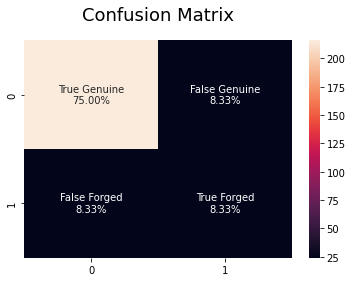

In [152]:
evaluate_model(test_triplets, 0.6)